# **Pymavlink Protocol**

Pymavlink is a python implementation of the MAVLink protocol. MAVLink is a lightweight communication library that is widely used for communicating with drones and ground control stations. It is designed to be used with microcontrollers and is used in many autopilots such as ArduPilot and PX4.

## **Imports**


In [1]:
from pymavlink import mavutil

## **Establishing a Connection**

The first step is establishing a link with the target vehicle. This can be done using a serial connection or a network connection. In this example, we will use a UDP connection to connect to the Navigator controller.

In [2]:
master = mavutil.mavlink_connection('udp:localhost:14445')

**Code Explainations**

| Line of Code | Explanation |
| --- | --- |
| `master = mavutil.mavlink_connection('udp:localhost:14445')` | This line of code is creating a MAVLink (Micro Air Vehicle Link) connection using the `mavutil.mavlink_connection` function from the `mavutil` module. The function takes a string argument that specifies the connection. In this case, `'udp:localhost:14445'` is used, which means it's creating a connection over UDP (User Datagram Protocol) to the localhost (the machine where the code is running) on port 14445. The result of this function call is a connection object, which is being stored in the variable `master`. This `master` object can then be used to send and receive MAVLink messages. |



It is worth noting here that the local udp port specified is likely incorrect and does not currently work for communication with the navigator. Since we are attempting to establish a connection with the navigator controller, and not the local machine, the 'localhost' portion should be changed to the IP address of the navigator controller. The port number should also be changed to the port number that the navigator controller is listening on. This was just discovered and has not yet been tested at the time of writing.

In [ ]:
master.wait_heartbeat()
print("Heartbeat from system (system %u component %u)" %
      (master.target_system, master.target_component))

**Code Explainations**

| Line of Code | Explanation |
| --- | --- |
| `master.wait_heartbeat()` | This line of code is calling the `wait_heartbeat` method on the `master` object. This method is used to wait for a heartbeat message from the MAVLink device. A heartbeat message is a type of MAVLink message that is periodically sent by the device to indicate that it is still operational. |
| `print("Heartbeat from system (system %u component %u)" % (master.target_system, master.target_component))` | This line prints the system ID and component ID of the MAVLink device that sent the heartbeat message. |



## **Set Flight Mode**

The following MAVLink command is used to set the vehicle into Guided mode. This allows for velcity commands to be sent to the vehicle. In our case, we will be sending only position commands to the vehicle for simplicity. 

In [ ]:
flight_mode = 4  

master.mav.command_long_send(
    master.target_system,         
    master.target_component,      
    mavutil.mavlink.MAV_CMD_DO_SET_MODE,  
    0,                            
    mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED,  
    flight_mode,           
    0,                            
    0,                            
    0,                            
    0,                            
    0                             
)

**Code Explainations**

| Line | Code | Explanation |
|------|------|-------------|
| 1 | `flight_mode = 4` | This line assigns the value `4` to the variable `flight_mode`. The value `4` is used to set the flight mode to "GUIDED". |
| 2-11 | `master.mav.command_long_send(` | This function call sends a 'COMMAND_LONG' message to the MAVLink device.|
| 3 | `master.target_system,` | Specifies the target system (drone) ID. This is where the command is being sent. |
| 4 | `master.target_component,` | Specifies the target component ID within the system, in our case the Navigator flight controller. |
| 5 | `mavutil.mavlink.MAV_CMD_DO_SET_MODE,` | This is the command being sent. `MAV_CMD_DO_SET_MODE` tells the drone to change its mode. |
| 6 | `0,` | The first parameter of the command `0` means no confirmation is needed. That is groundcontrol will not wait to receive any messages from the vehicle before executing the following parameters. |
| 7 | `mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED,` | The second parameter. This flag indicates that a custom mode is being set. |
| 8 | `flight_mode,` | The third parameter, which here is the flight mode to set. The variable `flight_mode` holds the value `4`, as set earlier to enter the vehicle in to "GUIDED" mode, this is necessary for further waypoint commands. |
| 9-11 | `0, 0, 0, 0, 0` | These are additional parameters for the command, not used in this specific command, hence set to `0`. |

## **Arming the Drone**

The next MAVLink command is used to arm the vehicle. This is necessary before sending any movement commands to the vehicle.

In [ ]:
master.mav.command_long_send(
    master.target_system, 
    master.target_component, 
    mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
    0, 1, 0, 0, 0, 0, 0, 0)

This code is very similar to the previous command, but with a different command being sent. The command being sent here is `MAV_CMD_COMPONENT_ARM_DISARM`, which is a constant in `mavutil.mavlink` that tells the drone to arm or disarm itself. The second parameter of the command is `1`, which means to arm the vehicle. The other parameters are set to `0` and are not used.

## **Position Command**

The next MAVLink command is used to send a position command to the vehicle. This command is used to tell the vehicle to move to a specific 'waypoint' in space. The position is specified in terms of x, y, and z distance from the home position.  Typically, the home position is either set manually as the origin, or is set via GPS.

In [ ]:
master.mav.send(
    mavutil.mavlink.
    MAVLink_set_position_target_local_ned_message(
        0,
        master.target_system,
        master.target_component,
        mavutil.mavlink.MAV_FRAME_LOCAL_NED,
        int(0b100111111000),
        -30, -30, 10,
        0, 0, 0,
        0, 0, 0,
        3.927, 0
    ))

| Line | Code | Explanation |
|------|------|-------------|
| 1 | `master.mav.send(` | `send` is used to send a MAVLink message to the drone. |
| 2 | `mavutil.mavlink.` | This specifies that we are using the `mavutil.mavlink` module of the `pymavlink` library. |
| 3-4 | `MAVLink_set_position_target_local_ned_message(` | This message type is used to set a local position target in north, east, down (NED) coordinates. |
| 5 | `0,` | The first parameter is the time since boot in milliseconds. `0` implies use the current time. |
| 6 | `master.target_system,` | Specifies the target system ID. |
| 7 | `master.target_component,` | Specifies the target component ID. |
| 8 | `mavutil.mavlink.MAV_FRAME_LOCAL_NED,` | This sets the coordinate frame. `MAV_FRAME_LOCAL_NED` means North-East-Down local coordinate frame. |
| 9 | `int(0b100111111000),` | This is a bitmask to specify which parts of the message are ignored. Here `0b100111111000` is a binary literal that sets the message to ignore acceleration, velocity, and yaw rate parameters. It also sets the message to accept x, y, and z position coordinates, as well as the 'yaw' heading angle. |
| 10 | `-30, -30, 10,` | These are the x, y, z coordinates in the NED frame. `-30` for north and east, and `10` for down. |
| 11 | `0, 0, 0,` | These are the x, y, z velocity in m/s. Here, all set to `0`. |
| 12 | `0, 0, 0,` | These are the x, y, z acceleration (or force) in m/s². Also set to `0`. |
| 13 | `3.927, 0` | The final parameters are yaw and yaw rate. `3.927` is the yaw in radians, and `0` is the yaw rate in rad/s. |

This sets the initial mission waypoint. The two subsequent waypoints are set in the same way, with the x, y, and z coordinates and 'yaw' heading angle being changed to the desired values.

In [ ]:
master.mav.send(
    mavutil.mavlink.
    MAVLink_set_position_target_local_ned_message(
        0,
        master.target_system,
        master.target_component,
        mavutil.mavlink.MAV_FRAME_LOCAL_NED,
        int(0b100111111000),
        -30, 30, 10,
        0, 0, 0,
        0, 0, 0,
        1.5708, 0
    ))

master.mav.send(
    mavutil.mavlink.
    MAVLink_set_position_target_local_ned_message(
        0,
        master.target_system,
        master.target_component,
        mavutil.mavlink.MAV_FRAME_LOCAL_NED,
        int(0b100111111000),
        0, 0, 0,
        0, 0, 0,
        0, 0, 0,
        5.498, 0
    ))

## **Position Logging**

The following code is an attempt to extract positional data from the drone in real time. At the time of writing this code is functional and able to pull the position data, however there is currently a problem where this communication seems to overload the communication on the chosen ports. It is believed the problem lies in the way that the communication ports are set up, and that too much traffic is being sent on the chosen ports. This is currently being investigated.

In [ ]:
while True:
    msg = master.recv_match(
        type='LOCAL_POSITION_NED', blocking=True)
    print(msg)

| Line | Code | Explanation |
|------|------|-------------|
| 1 | `while True:` | This line starts an infinite loop. |
| 2-3 | `msg = master.recv_match(` | `recv_match` waits for a specific MAVLink message type. The variable `msg` will store the received message. |
| 4 | `type='LOCAL_POSITION_NED',` | `LOCAL_POSITION_NED` is a message type that contains the local position of the drone in North, East, Down (NED) coordinates. |
| 5 | `blocking=True)` | The `blocking=True` argument makes the `recv_match` method wait (or block) until the specified message type is received. Without this, the method would return `None` if the message type isn't immediately available. |
| 6 | `print(msg)` | This line prints the received message to the console. This is useful for monitoring the local position of the drone in real time. |

This script is a simple way to continuously monitor and print the local position (in NED coordinates) of a MAVLink-compatible drone. It should be noted that in it's current state the loop is infinite and would need to be terminated manually. Otherwise some form of interrupt would need to be implemented to stop the loop.

## **Dockerfile**

This dockerfile is used to build the dockerimage for later implementation in BlueOS. It will be implemented in a simlilar manner to the container project that has already demonstrated the ability to create a custom extension on the BlueOS platform. The dockerfile is used to build the image, and the image is then used to create a container. The container is then used to run the code on the BlueOS platform.

In [ ]:
# Use an official Python runtime as a parent image
FROM python:3.10.12-slim

# Set the working directory in the container
WORKDIR /usr/src/app

# Copy only the files we need
COPY mission.py ./
COPY requirements.txt ./

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip && pip install --no-cache-dir -r requirements.txt

# Command to keep the container running
CMD ["tail", "-f", "/dev/null"]

**Code Explainations**

| Line | Code | Explanation |
|------|------|-------------|
| 2 | `FROM python:3.10.12-slim` | This line specifies the base image. Here, it's using a slim version of Python 3.10.12. This base image contains Python, slim indicates that only minimal necessary components to run Python are loaded, making the image smaller and faster to build. |
| 4 | `WORKDIR /usr/src/app` | Sets the working directory inside the Docker container. |
| 6 | `COPY mission.py ./` | Copies the `mission.py` file from your project into the container's working directory. |
| 7 | `COPY requirements.txt ./` | Copies the `requirements.txt` file into the container's working directory. This file lists the Python dependencies for the project. |
| 9 | `RUN pip install --upgrade pip && pip install --no-cache-dir -r requirements.txt` | This line updates `pip` to the latest version and then installs the Python packages specified in `requirements.txt`. |
| 11 | `CMD ["tail", "-f", "/dev/null"]` | This command keeps the container running by executing `tail -f /dev/null`. Without a process to keep it running, a Docker container would exit immediately after start. This is currently being used for manually testing the script in the container, later iterations will likely omit this.|

This Dockerfile is a configuration file for creating a Docker image. It defines the environment for running a Python application (`mission.py` in this case), specifying the Python version, the working directory, the necessary files, and the dependencies that need to be installed. The final command ensures that the container keeps running after being started. In order to run 'mission.py' the container must be accessed and the file must be run mannually. This dockerfile could be augmented in order to run 'mission.py' automatically upon starting the container.

## **Current Working Directory**

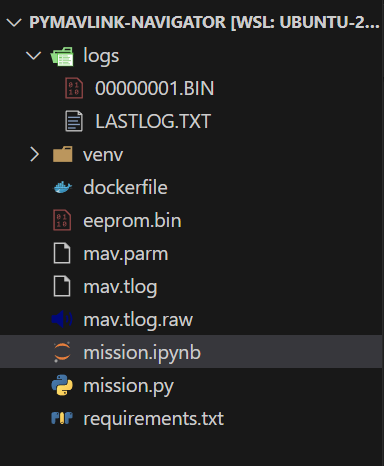